In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.networks import ScoreNet
from sdebridge.utils import *

plt.style.use('ggplot')

# Ornstein-Uhlenbeck Process
Forward SDE:
$$ dX_t = -\gamma X_t dt + \sigma dW_t $$
With the forward transition density (from solving Fokker-Planck equation):
$$ p(x_t,t|x_s,s) = \sqrt{\frac{\gamma}{2\pi D(1-\exp(-2\gamma(t-s)))}}\exp\left[ -\frac{\gamma}{2D} \frac{\|x_t-x_s\exp(-\gamma(t-s))\|^2}{1-\exp(-2\gamma(t-s))}\right] $$
with $D = \sigma^2/2$
Then the analytical score of the forward transition density from $0$ to $t$ is:
$$\nabla_{x_t}\log p(x_t, t|x_0, 0) = -\frac{\gamma}{D} \frac{1}{1-\exp(-2\gamma t)}\cdot(x_t-x_0e^{-\gamma t})$$

### 2D case

In [3]:
d = 2
gamma = 1.0
sigma = 0.5
D = sigma**2 / 2

def drift(val, time):
    return -gamma * val

def diffusion(val, time): 
    return sigma * jnp.eye(d) 

def true_score_transition(val, time, start_val):
    return (-gamma / D) * (1 / (1 - jnp.exp(-2 * gamma * time))) * (val - start_val*jnp.exp(-gamma * time))

model = DiffusionBridge(
    drift=drift,
    diffusion=diffusion,
    dim=d,
    end_time=1.0,
    num_steps=100,
    true_score_transition=true_score_transition,
)

(32, 101, 2)
(32, 100, 2)


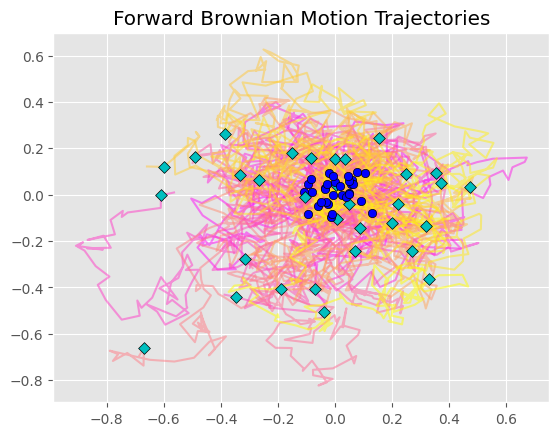

In [6]:
X0 = jnp.array([[0.0, 0.0]])
num_batches = 32

forward_brownian_motion= model.simulate_forward_process(initial_condition=jnp.tile(X0, reps=(num_batches, 1)))
print(forward_brownian_motion["trajectories"].shape)
print(forward_brownian_motion["scaled_brownians"].shape)
plot_2d_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [8]:
train_params = {"batch_size": 64, "num_epochs": 25, "num_batches_per_epoch": 50, "learning_rate": 5e-3}
# score_transition_net = ScoreNet(out_dim=model.d,
#                                 time_embedding_dim=64,
#                                 embedding_dim=64,
#                                 act='leaky_relu',
#                                 encoder_layer_dims=[64, 64],
#                                 decoder_layer_dims=[64, 64],
#                                 using_batchnorm=False)
# score_transition_state = model.learn_forward_transition_score(score_transition_net, 
#                                                               initial_condition=X0, 
#                                                               training_params=train_params)
setup_params = {
    "network": {"out_dim": model.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'leaky_relu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_transition_state = model.learn_p_score(initial_condition=X0, 
                                    setup_params=setup_params)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

KeyboardInterrupt: 

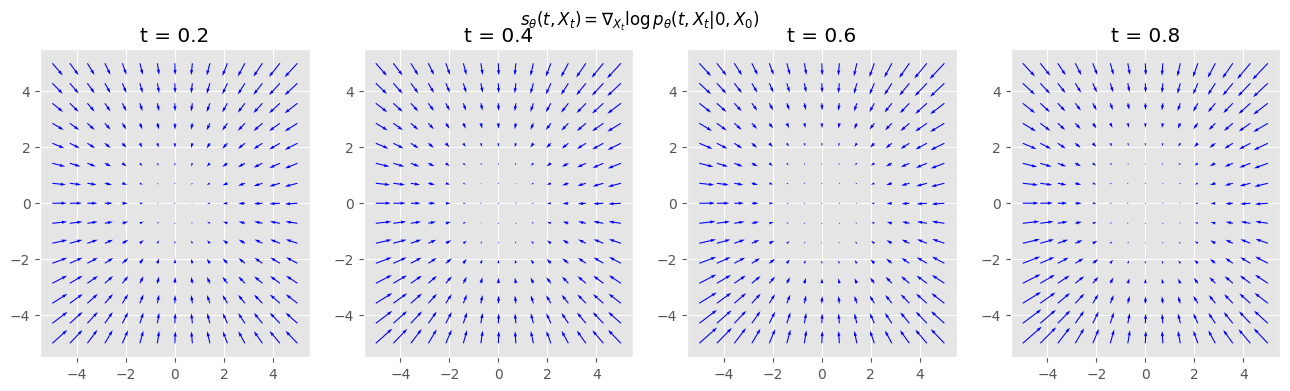

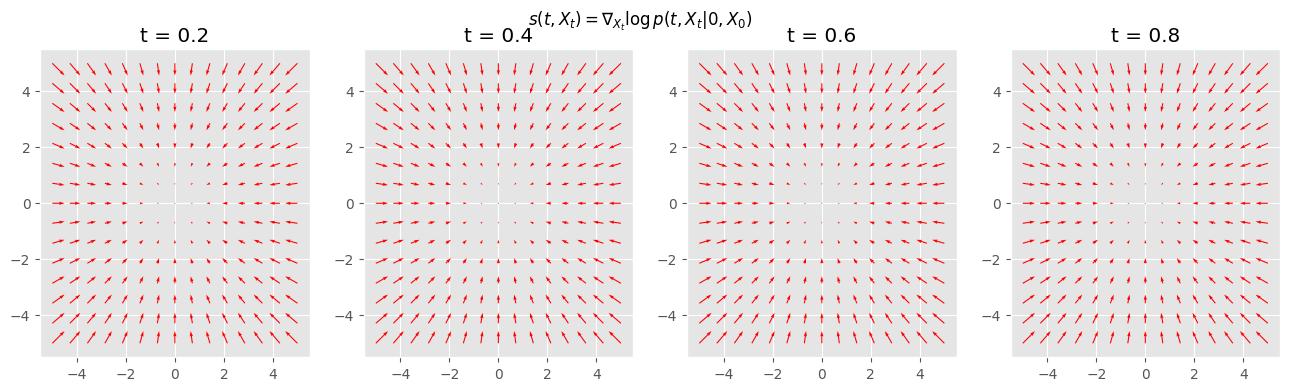

In [21]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_transition_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t)=\nabla_{X_t}\log p_{\theta}(t, X_t|0, X_0)$",
                     scale=None)

plot_2d_vector_field(X=None,
                     X_ref=model.true_score_transition,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s(t, X_t)=\nabla_{X_t}\log p(t,X_t|0,X_0)$",
                     scale=None,
                     x0=X0)

# plot_2d_vector_field(X=None,
#                      X_ref=lambda x, t, x0: eval_score(score_transition_state, x, t) - model.true_score_transition(x, t, x0),
#                      xs=jnp.linspace(-5.0, 5.0, 15),
#                      ts=jnp.linspace(0.2, 0.8, 3+1),
#                      suptitle=r"$s_{\theta}(t, X_t) - s(t, X_t)$",
#                      scale=200,
#                      x0=X0)

(32, 101, 2)


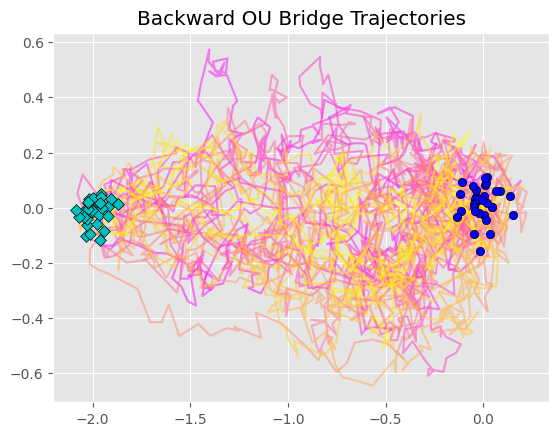

In [24]:
Z0 = jnp.array([[-2.0, 0.0]])

backward_brownian_bridge = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                                       initial_condition=jnp.tile(Z0, reps=(num_batches, 1)), 
                                                                       terminal_condition=jnp.tile(X0, reps=(num_batches, 1)), 
                                                                       using_true_score=False)
print(backward_brownian_bridge["trajectories"].shape)
plot_2d_trajectories(backward_brownian_bridge["trajectories"], title="Backward OU Bridge Trajectories")

### High dimension

In [72]:
d = 32
gamma = 1.0
sigma = 0.5

def drift(val, time):
    return -gamma * val

def diffusion(val, time): 
    return sigma * jnp.eye(d) 

model = DiffusionBridge(
    drift=drift,
    diffusion=diffusion,
    dim=d,
    end_time=1.0,
    num_steps=100,
    true_score_transition=None,
    true_score_h=None,
)

(32,) (32,)


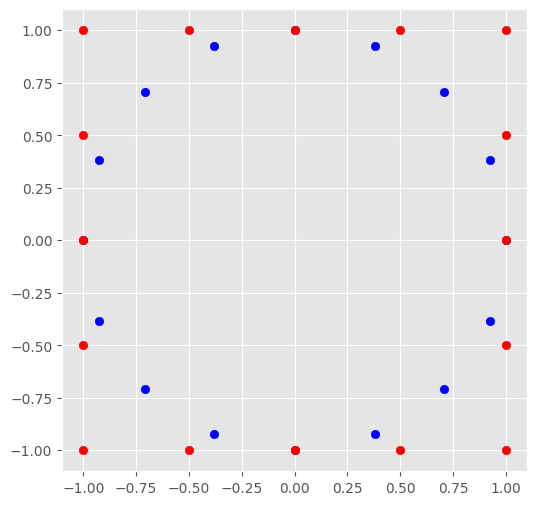

In [73]:
circles = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
squares = sample_square(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(circles.reshape(-1, 2)[:, 0], circles.reshape(-1, 2)[:, 1], color='b')
ax.scatter(squares.reshape(-1, 2)[:, 0], squares.reshape(-1, 2)[:, 1], color='r')
print(circles.shape, squares.shape)

(1, 101, 32)


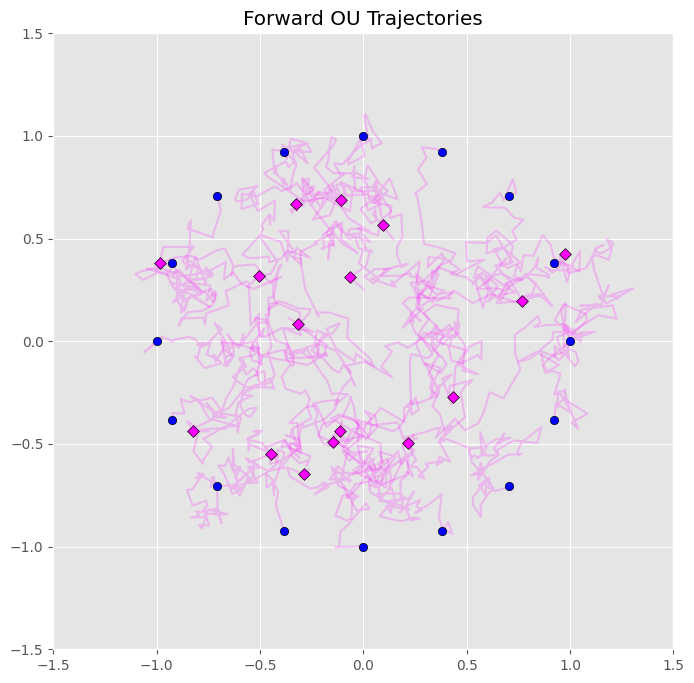

In [76]:
forward_brownian_motion = model.simulate_forward_process(initial_condition=jnp.tile(circles, reps=(1, 1)))
print(forward_brownian_motion["trajectories"].shape)
plot_trajectories(forward_brownian_motion["trajectories"], title="Forward OU Trajectories")

In [77]:
train_params = {"batch_size": 64, "num_epochs": 50, "num_batches_per_epoch": 50, "learning_rate": 1e-2}
score_transition_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=128,
                                embedding_dim=128,
                                act='leaky_relu',
                                encoder_layer_dims=[128, 128],
                                decoder_layer_dims=[128, 128],
                                using_batchnorm=True)
score_transition_state = model.learn_forward_transition_score(score_transition_net, 
                                                              initial_condition=circles, 
                                                              training_params=train_params)

Epoch 1 / 50: loss = 384.5654
Epoch 2 / 50: loss = 378.1298
Epoch 3 / 50: loss = 376.1218
Epoch 4 / 50: loss = 374.6995
Epoch 5 / 50: loss = 374.2443
Epoch 6 / 50: loss = 373.9413
Epoch 7 / 50: loss = 373.9365
Epoch 8 / 50: loss = 373.6765
Epoch 9 / 50: loss = 373.5139
Epoch 10 / 50: loss = 373.3081
Epoch 11 / 50: loss = 373.3041
Epoch 12 / 50: loss = 373.1146
Epoch 13 / 50: loss = 372.8453
Epoch 14 / 50: loss = 372.8311
Epoch 15 / 50: loss = 373.1206
Epoch 16 / 50: loss = 373.0610
Epoch 17 / 50: loss = 372.9108
Epoch 18 / 50: loss = 372.5330
Epoch 19 / 50: loss = 372.5625
Epoch 20 / 50: loss = 372.7839
Epoch 21 / 50: loss = 372.7750
Epoch 22 / 50: loss = 372.3055
Epoch 23 / 50: loss = 372.5339
Epoch 24 / 50: loss = 372.6385
Epoch 25 / 50: loss = 372.4969
Epoch 26 / 50: loss = 372.4651
Epoch 27 / 50: loss = 372.6097
Epoch 28 / 50: loss = 372.3972
Epoch 29 / 50: loss = 372.4232
Epoch 30 / 50: loss = 372.5052
Epoch 31 / 50: loss = 372.2390
Epoch 32 / 50: loss = 372.6528
Epoch 33 / 50: lo

(1, 101, 32)


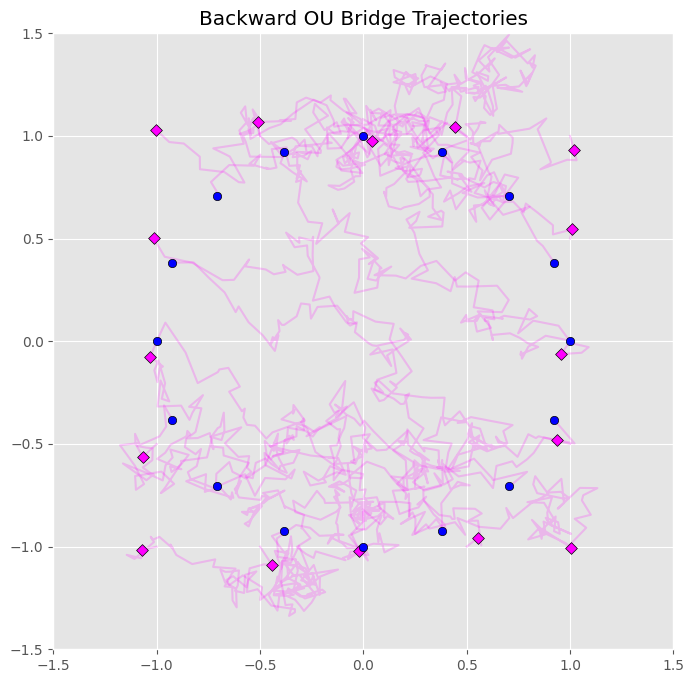

In [78]:
backward_brownian_bridge = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                            initial_condition=jnp.tile(squares, reps=(1, 1)), 
                                                            terminal_condition=jnp.tile(circles, reps=(1, 1)), 
                                                            using_true_score=False)
print(backward_brownian_bridge["trajectories"].shape)
plot_trajectories(backward_brownian_bridge["trajectories"], title="Backward OU Bridge Trajectories")